In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mediapipe as mp
import pandas as pd
from PIL import Image
import seaborn as sns
import pickle

In [11]:
print(tf.__version__)
print(cv2.__version__)

2.19.0
4.11.0


In [12]:
#Setting Dataset paths here

TRAIN_PATH = r"dataset\asl_alphabet_train\asl_alphabet_train"
TEST_PATH = r"dataset\asl_alphabet_test\asl_alphabet_test"

IMAGE_SIZE = (64,64)
BATCH_SIZE = 32
EPOCHS = 20

In [13]:
# ASL alphabet classes

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
           'del', 'nothing', 'space']

print(f"Number of classes: {len(classes)}")

Number of classes: 29


In [14]:
def load_training_dataset(train_path):
    """Load and preprocess the ASL training dataset"""
    images = []
    labels = []
    
    print("Loading training dataset...")
    
    # Sort class names to ensure consistent ordering
    class_names = sorted([name for name in os.listdir(train_path) 
                         if os.path.isdir(os.path.join(train_path, name))])
    
    for class_name in class_names:
        class_path = os.path.join(train_path, class_name)
        print(f"Loading class: {class_name} - ", end="")
        count = 0
        
        # Get list of image files and filter by extension
        img_files = [f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            
            try:
                # Load and preprocess image
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, IMAGE_SIZE)
                    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
                    
                    images.append(img)
                    labels.append(class_name)
                    count += 1
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        print(f"{count} images loaded")
    
    print(f"Total images loaded: {len(images)}")
    print(f"Unique labels: {len(set(labels))}")
    
    return np.array(images), np.array(labels)

In [15]:
def load_test_dataset(test_path):
    """Load and preprocess the ASL test dataset"""
    images = []
    labels = []
    
    print("Loading test dataset...")
    
    # Dictionary to count images per class
    class_counts = {}
    
    for img_name in os.listdir(test_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Extract class name from filename (e.g., 'A_test.jpg' -> 'A')
            if '_test' in img_name:
                class_name = img_name.split('_test')[0]
                img_path = os.path.join(test_path, img_name)
                
                try:
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, IMAGE_SIZE)
                        img = img.astype(np.float32) / 255.0  # Consistent normalization
                        
                        images.append(img)
                        labels.append(class_name)
                        
                        # Count images per class
                        if class_name not in class_counts:
                            class_counts[class_name] = 0
                        class_counts[class_name] += 1
                    
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Print counts per class
    for class_name, count in sorted(class_counts.items()):
        print(f"Class {class_name}: {count} test images")
    
    return np.array(images), np.array(labels)

In [16]:
# load the datasets
print("="*50)
print("LOADING DATASETS")
print("="*50)

LOADING DATASETS


In [17]:
print(X_train.shape)

(3, 64, 64, 3)


In [18]:
# Load Training Data
X_train, y_train = load_training_dataset(TRAIN_PATH)
print(f"\nTraining dataset loaded: {X_train.shape[0]} images")
print(f"Training data shape: {X_train.shape}")
print(f"Unique training classes: {len(np.unique(y_train))}")

Loading training dataset...
Loading class: A - 3000 images loaded
Loading class: B - 3000 images loaded
Loading class: C - 3000 images loaded
Loading class: D - 3000 images loaded
Loading class: E - 3000 images loaded
Loading class: F - 3000 images loaded
Loading class: G - 3000 images loaded
Loading class: H - 3000 images loaded
Loading class: I - 3000 images loaded
Loading class: J - 3000 images loaded
Loading class: K - 3000 images loaded
Loading class: L - 3000 images loaded
Loading class: M - 3000 images loaded
Loading class: N - 3000 images loaded
Loading class: O - 3000 images loaded
Loading class: P - 3000 images loaded
Loading class: Q - 3000 images loaded
Loading class: R - 3000 images loaded
Loading class: S - 3000 images loaded
Loading class: T - 3000 images loaded
Loading class: U - 3000 images loaded
Loading class: V - 3000 images loaded
Loading class: W - 3000 images loaded
Loading class: X - 3000 images loaded
Loading class: Y - 3000 images loaded
Loading class: Z - 300

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Split training data into train + validation (e.g., 80% train, 20% val)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Fit label encoder on training labels only
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_split)
y_val_encoded = le.transform(y_val)

# Convert to categorical (one-hot)
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)

In [22]:
# Load test data
X_test, y_test = load_test_dataset(TEST_PATH)
print(f"\nTest dataset loaded: {X_test.shape[0]} images")
print(f"Test data shape: {X_test.shape}")
print(f"Unique test classes: {len(np.unique(y_test))}")

Loading test dataset...
Class A: 1 test images
Class B: 1 test images
Class C: 1 test images
Class D: 1 test images
Class E: 1 test images
Class F: 1 test images
Class G: 1 test images
Class H: 1 test images
Class I: 1 test images
Class J: 1 test images
Class K: 1 test images
Class L: 1 test images
Class M: 1 test images
Class N: 1 test images
Class O: 1 test images
Class P: 1 test images
Class Q: 1 test images
Class R: 1 test images
Class S: 1 test images
Class T: 1 test images
Class U: 1 test images
Class V: 1 test images
Class W: 1 test images
Class X: 1 test images
Class Y: 1 test images
Class Z: 1 test images
Class nothing: 1 test images
Class space: 1 test images

Test dataset loaded: 28 images
Test data shape: (28, 64, 64, 3)
Unique test classes: 28


In [23]:
y_test_encoded = le.transform(y_test)  # le from training phase
y_test_cat = to_categorical(y_test_encoded, num_classes=len(le.classes_))

In [25]:
X_test, y_test = load_test_dataset(TEST_PATH)
print(X_test.shape, y_test.shape)

Loading test dataset...
Class A: 1 test images
Class B: 1 test images
Class C: 1 test images
Class D: 1 test images
Class E: 1 test images
Class F: 1 test images
Class G: 1 test images
Class H: 1 test images
Class I: 1 test images
Class J: 1 test images
Class K: 1 test images
Class L: 1 test images
Class M: 1 test images
Class N: 1 test images
Class O: 1 test images
Class P: 1 test images
Class Q: 1 test images
Class R: 1 test images
Class S: 1 test images
Class T: 1 test images
Class U: 1 test images
Class V: 1 test images
Class W: 1 test images
Class X: 1 test images
Class Y: 1 test images
Class Z: 1 test images
Class nothing: 1 test images
Class space: 1 test images
(28, 64, 64, 3) (28,)


In [26]:
print(f"\nTraining classes: {sorted(np.unique(y_train))}")
print(f"Test classes: {sorted(np.unique(y_test))}")


Training classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Test classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


In [28]:
# Visualize samples from training data

def visualize_training_samples(X_train, y_train, n_samples = 25):
    """Visualize sample images from each class"""
    plt.figure(figsize=(15,12))
    unique_classes = sorted(np.unique(y_train))
    for i, class_name in enumerate(unique_classes[:n_samples]):
        class_indices = np.where(y_train == class_name)[0]
        if len(class_indices) > 0:
            img_idx = class_indices[0]
            plt.subplot(5, 5, i + 1)
            plt.imshow(X_train[img_idx])
            plt.title(f"Class:{class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

In [29]:
# Show class distribution

def show_class_distribution(y_train,y_test):
    """Show distribution of classes in training and test sets"""
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    train_counts = pd.Series(y_train).value_counts().sort_index()
    train_counts.plot(kind='bar')
    plt.title('Training Set Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1,2,2)
    test_counts = pd.Series(y_test).value_counts().sort_index()
    test_counts.plot(kind='bar')
    plt.title('Test Set Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("Training set class counts:")
    print(train_counts)
    print("\nTest set class counts:")
    print(test_counts)

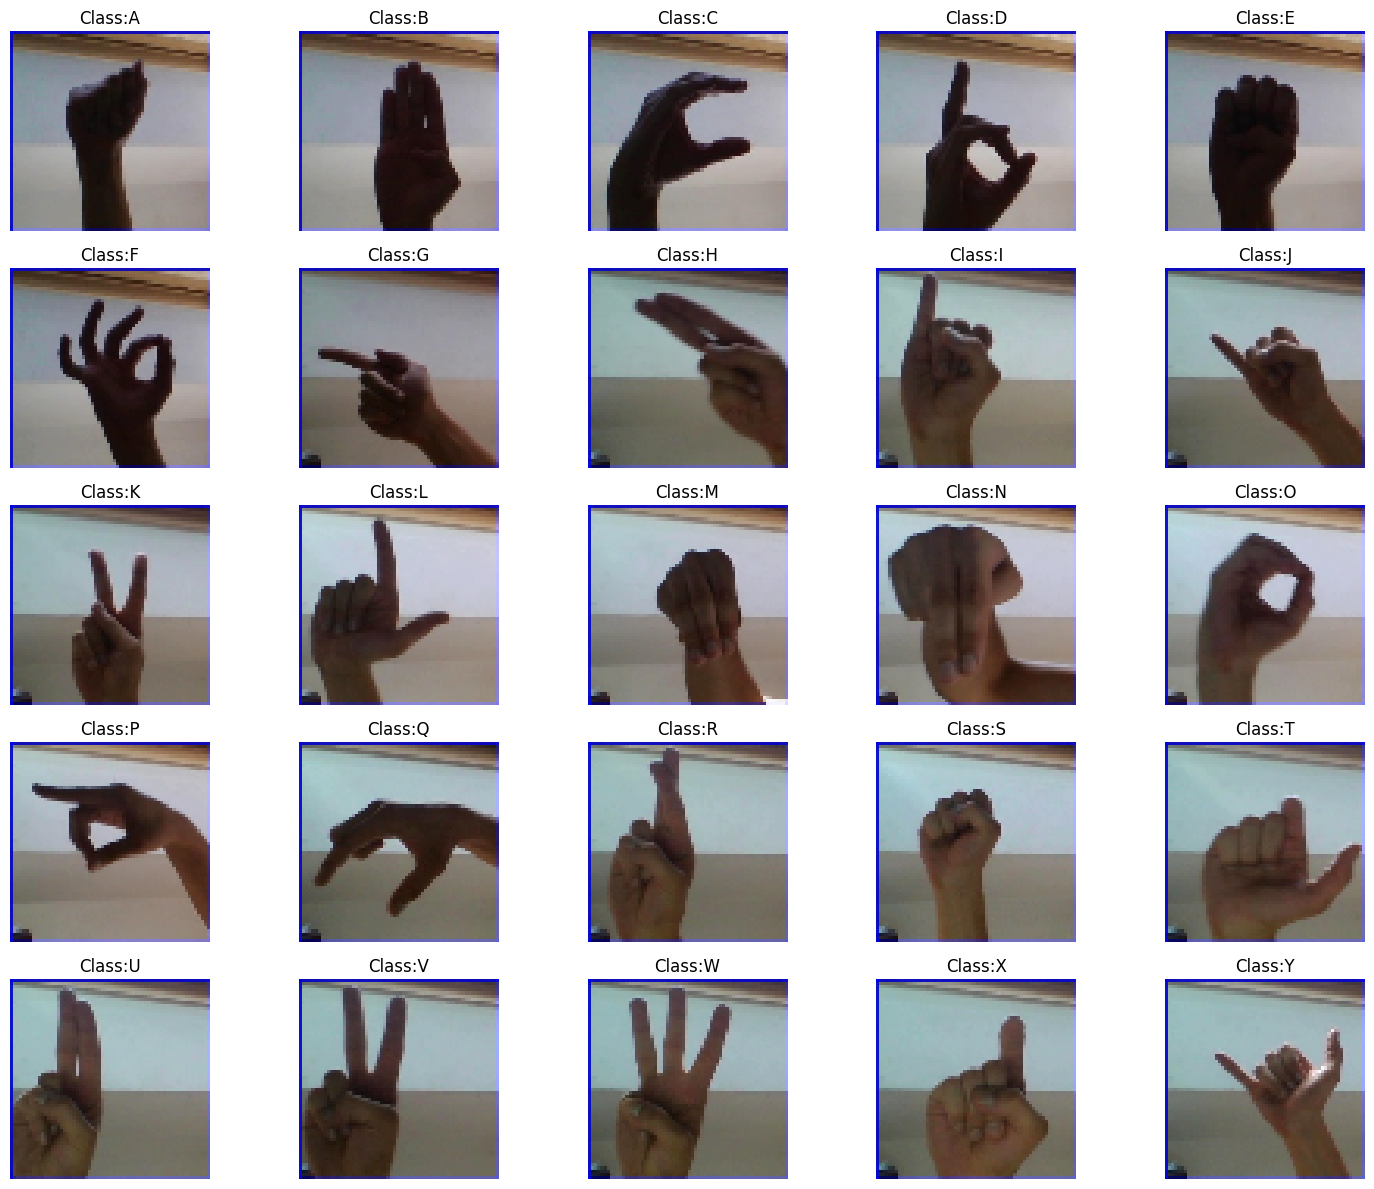

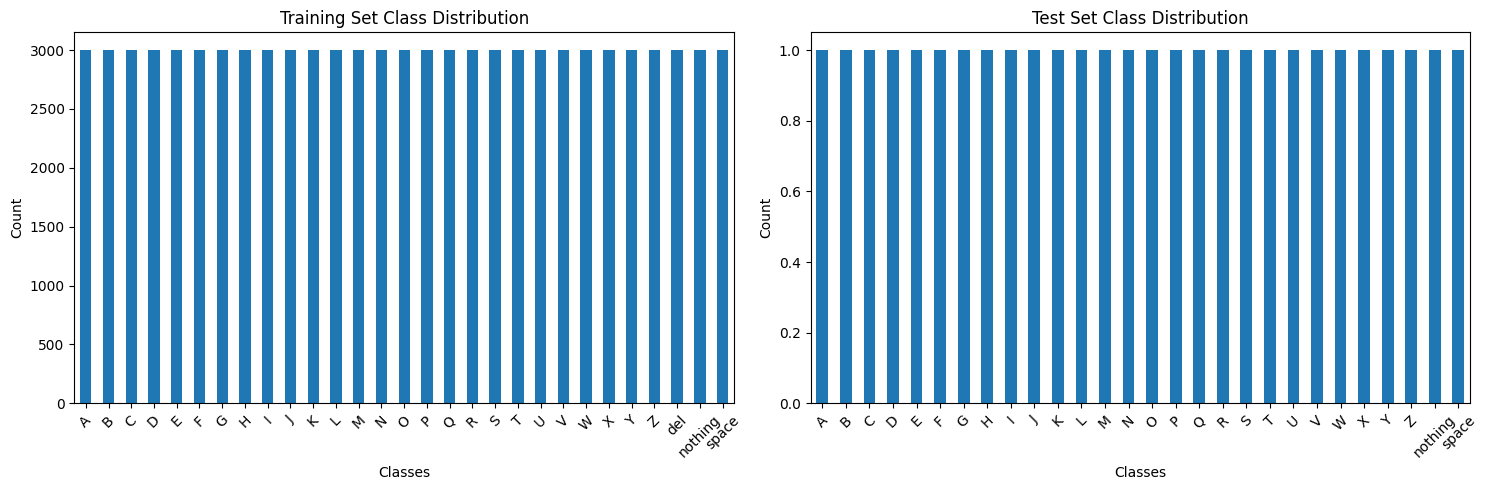

Training set class counts:
A          3000
B          3000
C          3000
D          3000
E          3000
F          3000
G          3000
H          3000
I          3000
J          3000
K          3000
L          3000
M          3000
N          3000
O          3000
P          3000
Q          3000
R          3000
S          3000
T          3000
U          3000
V          3000
W          3000
X          3000
Y          3000
Z          3000
del        3000
nothing    3000
space      3000
Name: count, dtype: int64

Test set class counts:
A          1
B          1
C          1
D          1
E          1
F          1
G          1
H          1
I          1
J          1
K          1
L          1
M          1
N          1
O          1
P          1
Q          1
R          1
S          1
T          1
U          1
V          1
W          1
X          1
Y          1
Z          1
nothing    1
space      1
Name: count, dtype: int64


In [30]:
# Data Visualization
visualize_training_samples(X_train, y_train)
show_class_distribution(y_train, y_test)

In [31]:
from tensorflow.keras import Input

def create_cnn_model(input_shape, num_classes):
    """Create CNN model for ASL recognition"""
    model = Sequential([
        Input(shape=input_shape),  

        # First Convolutional Block
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Second Convolution Block
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Third Convolution Block
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Fourth Convolution Block
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        # Flatten and Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [32]:
model = create_cnn_model((*IMAGE_SIZE, 3), len(classes))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,051,997 (4.01 MB)

 Trainable params: 1,051,997 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# compiling the model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = False,
    fill_mode='nearest'
)

In [35]:
# Training function updated to handle class mismatch and return model
def train_model_with_test_data(model, X_train, y_train, X_test, y_test):
    """Train the ASL model using separate train and test sets"""
    
    # Convert labels to categorical
    from tensorflow.keras.utils import to_categorical
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.optimizers import Adam
    
    # Check for class mismatches
    train_classes = set(np.unique(y_train))
    test_classes = set(np.unique(y_test))
    
    print("Class Analysis:")
    print(f"Training classes: {sorted(train_classes)}")
    print(f"Test classes: {sorted(test_classes)}")
    print(f"Classes only in training: {sorted(train_classes - test_classes)}")
    print(f"Classes only in test: {sorted(test_classes - train_classes)}")
    
    common_classes = train_classes.intersection(test_classes)
    print(f"\nUsing common classes: {sorted(common_classes)}")
    
    # Filter training data to only include common classes
    train_mask = np.isin(y_train, list(common_classes))
    X_train_filtered = X_train[train_mask]
    y_train_filtered = y_train[train_mask]
    
    print(f"Original training samples: {len(X_train)}")
    print(f"Filtered training samples: {len(X_train_filtered)}")
    
    # Fit label encoder on common classes only
    le = LabelEncoder()
    le.fit(sorted(list(common_classes)))  # Sort for consistency
    
    # Transform labels
    y_train_encoded = le.transform(y_train_filtered)
    y_test_encoded = le.transform(y_test)
    
    y_train_cat = to_categorical(y_train_encoded, num_classes=len(le.classes_))
    y_test_cat = to_categorical(y_test_encoded, num_classes=len(le.classes_))
    
    print(f"Number of classes for training: {len(le.classes_)}")
    print(f"Final classes: {le.classes_}")
    
    # Update model output layer to match number of classes
    # Instead of modifying the existing model, let's rebuild the last layer properly
    model.pop()  # Remove last layer
    model.add(Dense(len(le.classes_), activation='softmax', name='predictions'))
    
    # Recompile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Split filtered training data into train/validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_filtered, y_train_cat, test_size=0.2, random_state=42, 
        stratify=y_train_cat.argmax(axis=1)
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(patience=7, restore_best_weights=True, monitor='val_accuracy'),
        ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
        ModelCheckpoint('best_asl_model.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
    ]
    
    # Train the model
    print("\nStarting training...")
    history = model.fit(
        datagen.flow(X_train_split, y_train_split, batch_size=BATCH_SIZE),
        steps_per_epoch=len(X_train_split) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val_split, y_val_split),
        callbacks=callbacks,
        verbose=1
    )
    
    # Load the best model from checkpoint
    print("\nLoading best model from checkpoint...")
    try:
        model.load_weights('best_asl_model.h5')
        print("✓ Best weights loaded successfully")
    except Exception as e:
        print(f"Warning: Could not load best weights: {e}")
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Return the model along with history and label encoder
    return model, history, le

# Updated calling code
print("Training model...")
model, history, label_encoder = train_model_with_test_data(model, X_train, y_train, X_test, y_test)

# Now save the model (this should work)
try:
    model.save('asl_final_model.h5')
    print("\n✓ Model saved as 'asl_final_model.h5'")
    
    # Verify file was created
    import os
    if os.path.exists('asl_final_model.h5'):
        file_size = os.path.getsize('asl_final_model.h5')
        print(f"✓ Model file size: {file_size:,} bytes")
    
except Exception as e:
    print(f"✗ Error saving model: {e}")
    
    # Try alternative save method
    try:
        model.save_weights('asl_model_weights.h5')
        print("✓ Model weights saved as backup")
        
        # Save model architecture
        model_json = model.to_json()
        with open("asl_model_architecture.json", "w") as json_file:
            json_file.write(model_json)
        print("✓ Model architecture saved as backup")
        
    except Exception as e2:
        print(f"✗ Error with backup save: {e2}")

# Save label encoder
try:
    import pickle
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print("✓ Label encoder saved as 'label_encoder.pkl'")
    
    # Verify file was created
    if os.path.exists('label_encoder.pkl'):
        file_size = os.path.getsize('label_encoder.pkl')
        print(f"✓ Label encoder file size: {file_size} bytes")
        
except Exception as e:
    print(f"✗ Error saving label encoder: {e}")

# Print final class information
print(f"\n✓ Final model trained on {len(label_encoder.classes_)} classes:")
print(f"✓ Classes: {list(label_encoder.classes_)}")

# Test the saved model by loading it
try:
    from tensorflow.keras.models import load_model
    loaded_model = load_model('asl_final_model.h5')
    print("✓ Model successfully loaded and verified!")
    
    # Test prediction
    test_pred = loaded_model.predict(X_test[:1])
    print(f"✓ Test prediction shape: {test_pred.shape}")
    
except Exception as e:
    print(f"✗ Error loading saved model: {e}")

Training model...
Class Analysis:
Training classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Test classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
Classes only in training: ['del']
Classes only in test: []

Using common classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
Original training samples: 87000
Filtered training samples: 84000
Number of classes for training: 28
Final classes: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'nothing' 'space']

Starting training...


C:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3477 - loss: 2.1536
Epoch 1: val_accuracy improved from None to 0.93851, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 131s 61ms/step - accuracy: 0.6037 - loss: 1.2517 - val_accuracy: 0.9385 - val_loss: 0.1703 - learning_rate: 0.0010
Epoch 2/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8931 - loss: 0.3151
Epoch 2: val_accuracy improved from 0.93851 to 0.97464, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 129s 61ms/step - accuracy: 0.9087 - loss: 0.2697 - val_accuracy: 0.9746 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 3/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9359 - loss: 0.1921
Epoch 3: val_accuracy improved from 0.97464 to 0.98810, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 122s 58ms/step - accuracy: 0.9420 - loss: 0.1742 - val_accuracy: 0.9881 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 4/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9540 - loss: 0.1453
Epoch 4: val_accuracy improved from 0.98810 to 0.99065, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 128s 61ms/step - accuracy: 0.9573 - loss: 0.1369 - val_accuracy: 0.9907 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 5/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9610 - loss: 0.1233
Epoch 5: val_accuracy improved from 0.99065 to 0.99440, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 123s 58ms/step - accuracy: 0.9644 - loss: 0.1142 - val_accuracy: 0.9944 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 6/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9705 - loss: 0.0941
Epoch 6: val_accuracy did not improve from 0.99440
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 118s 56ms/step - accuracy: 0.9690 - loss: 0.1005 - val_accuracy: 0.9879 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 7/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9718 - loss: 0.0964
Epoch 7: val_accuracy did not improve from 0.99440
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 119s 57ms/step - accuracy: 0.9728 - loss: 0.0908 - val_accuracy: 0.9942 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 8/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9763 - loss: 0.0813
Epoch 8: val_accuracy improved from 0.99440 to 0.99512, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 119s 57ms/step - accuracy: 0.9759 - loss: 0.0825 - val_accuracy: 0.9951 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 9/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9781 - loss: 0.0789
Epoch 9: val_accuracy improved from 0.99512 to 0.99714, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 122s 58ms/step - accuracy: 0.9770 - loss: 0.0812 - val_accuracy: 0.9971 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 10/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9792 - loss: 0.0721
Epoch 10: val_accuracy improved from 0.99714 to 0.99762, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 118s 56ms/step - accuracy: 0.9779 - loss: 0.0763 - val_accuracy: 0.9976 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 11/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9808 - loss: 0.0686
Epoch 11: val_accuracy did not improve from 0.99762
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 118s 56ms/step - accuracy: 0.9802 - loss: 0.0710 - val_accuracy: 0.9966 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 12/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9786 - loss: 0.0728
Epoch 12: val_accuracy did not improve from 0.99762
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 120s 57ms/step - accuracy: 0.9796 - loss: 0.0710 - val_accuracy: 0.9951 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 13/20
2099/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9895 - loss: 0.0361
Epoch 13: val_accuracy improved from 0.99762 to 0.99851, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 119s 57ms/step - accuracy: 0.9909 - loss: 0.0319 - val_accuracy: 0.9985 - val_loss: 0.0040 - learning_rate: 5.0000e-04
Epoch 14/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9913 - loss: 0.0315
Epoch 14: val_accuracy improved from 0.99851 to 0.99940, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 123s 58ms/step - accuracy: 0.9923 - loss: 0.0281 - val_accuracy: 0.9994 - val_loss: 0.0018 - learning_rate: 5.0000e-04
Epoch 15/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9925 - loss: 0.0254
Epoch 15: val_accuracy did not improve from 0.99940
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 120s 57ms/step - accuracy: 0.9927 - loss: 0.0261 - val_accuracy: 0.9992 - val_loss: 0.0020 - learning_rate: 5.0000e-04
Epoch 16/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9929 - loss: 0.0279
Epoch 16: val_accuracy did not improve from 0.99940
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 121s 58ms/step - accuracy: 0.9927 - loss: 0.0276 - val_accuracy: 0.9987 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 17/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9924 - loss: 0.0266
Epoch 17: val_accuracy did not improve from 0.99940
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 122s 58ms/step - accuracy: 0.9923 - loss: 0.0274 - val_accuracy: 0.9992 - val_loss: 0.0022 - 

2100/2100 ━━━━━━━━━━━━━━━━━━━━ 127s 61ms/step - accuracy: 0.9962 - loss: 0.0136 - val_accuracy: 0.9995 - val_loss: 0.0012 - learning_rate: 2.5000e-04
Epoch 19/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9968 - loss: 0.0131
Epoch 19: val_accuracy improved from 0.99946 to 0.99952, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 122s 58ms/step - accuracy: 0.9966 - loss: 0.0137 - val_accuracy: 0.9995 - val_loss: 0.0022 - learning_rate: 2.5000e-04
Epoch 20/20
2099/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9960 - loss: 0.0123
Epoch 20: val_accuracy improved from 0.99952 to 0.99958, saving model to best_asl_model.h5


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - accuracy: 0.9960 - loss: 0.0132 - val_accuracy: 0.9996 - val_loss: 0.0015 - learning_rate: 2.5000e-04

Loading best model from checkpoint...
✓ Best weights loaded successfully

Evaluating on test set...
Test Accuracy: 1.0000
Test Loss: 0.0000



✓ Model saved as 'asl_final_model.h5'
✓ Model file size: 12,684,560 bytes
✓ Label encoder saved as 'label_encoder.pkl'
✓ Label encoder file size: 1022 bytes

✓ Final model trained on 28 classes:
✓ Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


✓ Model successfully loaded and verified!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
✓ Test prediction shape: (1, 28)


In [36]:
# Train the model with data
print("="*50)
print("TRAINING MODEL")
print("="*50)

TRAINING MODEL


In [38]:
# === Self-check after saving ===

print("\n🔍 Starting self-check verification...")

try:
    from tensorflow.keras.models import load_model
    import pickle

    # Load model
    loaded_model = load_model('asl_final_model.h5')
    print("✓ Model successfully loaded.")

    # Load label encoder
    with open('label_encoder.pkl', 'rb') as f:
        loaded_le = pickle.load(f)
    print(f"✓ Label encoder loaded with classes: {list(loaded_le.classes_)}")

    # Verify test data shape (adapt if preprocessing is needed)
    print(f"Test data shape: {X_test.shape}")

    # Make a prediction on a single test sample
    sample_input = X_test[0:1]
    pred_probs = loaded_model.predict(sample_input)
    print(f"Prediction probabilities shape: {pred_probs.shape}")
    print(f"Raw prediction probabilities: {pred_probs}")

    pred_class_idx = np.argmax(pred_probs)
    pred_class_label = loaded_le.classes_[pred_class_idx]
    print(f"Predicted class index: {pred_class_idx}, Label: {pred_class_label}")

    # Compare with ground truth
    true_label_idx = loaded_le.transform([y_test[0]])[0]
    true_label = loaded_le.classes_[true_label_idx]
    print(f"Ground truth label: {true_label}")

    if pred_class_label == true_label:
        print("✓ Prediction matches ground truth. Self-check passed.")
    else:
        print("⚠️ Prediction does NOT match ground truth. Investigate further.")

except Exception as e:
    print(f"✗ Self-check verification failed: {e}")



🔍 Starting self-check verification...


✓ Model successfully loaded.
✓ Label encoder loaded with classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
Test data shape: (28, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction probabilities shape: (1, 28)
Raw prediction probabilities: [[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.6811930e-29
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.3042248e-32 1.5825466e-20 1.8064438e-34 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2148225e-25 1.6456959e-19
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.1824921e-24 1.5808877e-35
  3.6844334e-20 0.0000000e+00 0.0000000e+00]]
Predicted class index: 0, Label: A
Ground truth label: A
✓ Prediction matches ground truth. Self-check passed.


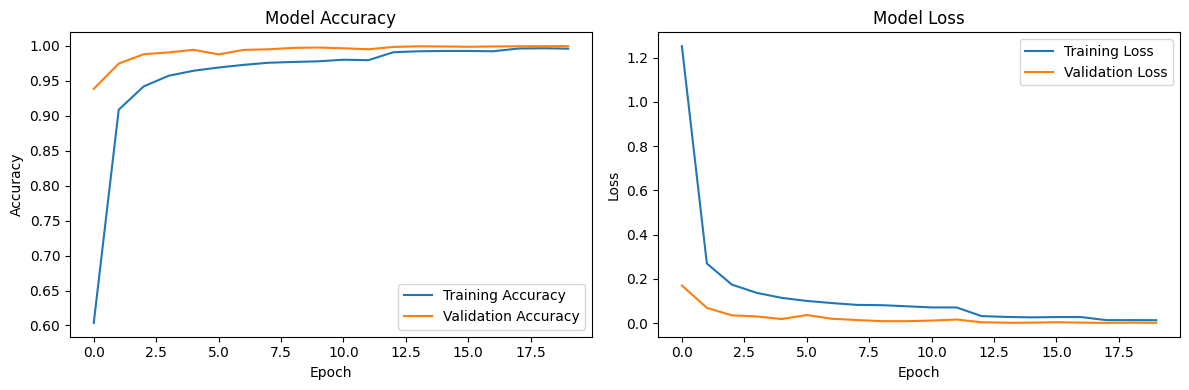

In [37]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation accuracy/loss"""
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)